In [1]:
from google.colab import drive

# Mount Google Drive at the specified pathm
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preprocessing

1. Extract position, velocity, and torque data measurements from CSV files

In [2]:
import pandas as pd
import numpy as np
import random
import os

# Initialize empty lists to store position, velocity, and torque data measurements from all trajectories
pos_data = []
vel_data = []
Pos = []
Vel = []
Trq = []
trajectory_lengths = []

# Specify the path to your data csv files
csv_folder = "/content/drive/MyDrive/EECE789K-Project/Data in CSV form"

# Extract position, velocity, and torque columns
pos_columns = [f"posa{i}.txt" for i in range(1, 6)]
vel_columns = [f"vela{i}.txt" for i in range(1, 6)]
trq_columns = [f"trq{i}.txt" for i in range(1, 6)]

# Shuffle the order of trajectories for later splitting
random.seed(42)
numbers = list(range(1, 13))
random.shuffle(numbers)

for j in numbers:
  # Read the CSV file corresponding to one trajectory
  csv_file = os.path.join(csv_folder, f"traj{j}.csv")

  df = pd.read_csv(csv_file)

  # Append position, velocity, and torque data measurements to lists
  pos_data = df[pos_columns].values
  vel_data = df[vel_columns].values
  trq_data = df[trq_columns].values
  Pos.append(pos_data)
  Vel.append(vel_data)
  Trq.append(trq_data)

  # Save the length (nb of samples) of each trajectory
  trajectory_lengths.append(len(pos_data))


# Concatenate position, velocity, and torque data from all trajectories
P = np.concatenate(Pos, axis=0)
V = np.concatenate(Vel, axis=0)
T = np.concatenate(Trq, axis=0)

# Print shapes
print("Shape of matrix P:", P.shape)
print("Shape of matrix V:", V.shape)
print("Shape of matrix T:", T.shape)

Shape of matrix P: (8513, 5)
Shape of matrix V: (8513, 5)
Shape of matrix T: (8513, 5)


2. Create Data matrix from joints positions and velocities and Output matrix from joints torques

In [3]:
#Data matrix
Data_matrix = np.concatenate((P, V), axis=1)
Data_matrix.shape

(8513, 10)

In [4]:
#output matrix
Output_matrix = T
Output_matrix.shape

(8513, 5)

In [5]:
# length of each trajectory
trajectory_lengths

[572, 966, 548, 564, 580, 624, 514, 754, 926, 710, 1154, 601]

3. Filter the Data with a low-pass filter to get rid of noise resulting from sensors

In [6]:
import numpy as np
from scipy.signal import butter,filtfilt


fs = 1000.0      # sample rate (Hz)
cutoff = 10      # desired cutoff frequency of the filter (Hz)
nyq = 0.5 * fs   # Nyquist Frequency (Hz)
order = 2        # signal can be approximately represented as quadratic


def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [7]:
# Filter torque measurements
Output_matrix_filtered = np.zeros((Output_matrix.shape[0], Output_matrix.shape[1]))

for i in range(Output_matrix.shape[1]):
    Output_matrix_filtered[:, i] = butter_lowpass_filter(Output_matrix[:,i], cutoff, fs, order)

In [8]:
# Filter position and velocity measurements
Data_matrix_filtered = np.zeros((Data_matrix.shape[0], Data_matrix.shape[1]))

for i in range(Data_matrix.shape[1]):
    Data_matrix_filtered[:, i] = butter_lowpass_filter(Data_matrix[:,i], cutoff, fs, order)

4. Visualize both original and filtered data for the five joints on a sample trajectory

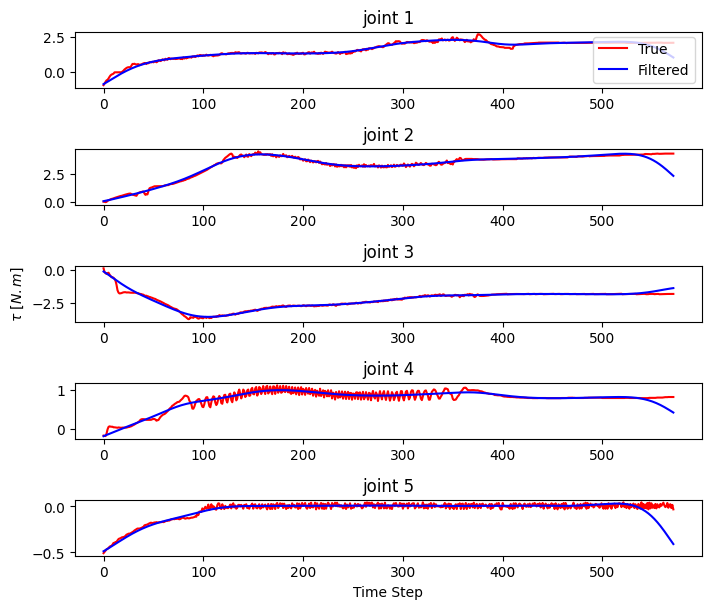

In [9]:
# Visualize original and filtered torque data on the first trajectory

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(Output_matrix[:trajectory_lengths[0], k], label='True', color='red')
  ax.plot(Output_matrix_filtered[:trajectory_lengths[0], k], label='Filtered', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.show()

5- Construct sequences of size n (we choose 500) to train the LSTM using Keras

In [10]:
#find the indices of the original trajectories using their lengths
original_traj_indices = [0] + list(np.cumsum(trajectory_lengths)[:-1])
original_traj_indices

[0, 572, 1538, 2086, 2650, 3230, 3854, 4368, 5122, 6048, 6758, 7912]

In [11]:
#Calculate new lengths for each trajectory that are multiples of 500
L = 500
new_trajectory_lengths = [(length // L) * L for length in trajectory_lengths]
new_trajectory_lengths

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 1000, 500]

In [12]:
#find the new indices of each trajectory
new_traj_indices = [0] + list(np.cumsum(new_trajectory_lengths)[:-1])
new_traj_indices

[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000]

In [13]:
new_nb_datapoints = np.array(new_trajectory_lengths).sum()
new_nb_datapoints

6500

In [14]:
# Adjust Data_matrix in order to take the trajectories of the new lengths (500)
Data_matrix_adjusted = np.zeros((new_nb_datapoints, Data_matrix_filtered.shape[1]), dtype=Data_matrix_filtered.dtype)
Output_matrix_adjusted = np.zeros((new_nb_datapoints, Output_matrix_filtered.shape[1]), dtype=Output_matrix_filtered.dtype)
Data_matrix_adjusted.shape, Output_matrix_adjusted.shape

((6500, 10), (6500, 5))

In [15]:
start_idx = 0
for i,length in enumerate (new_trajectory_lengths):
    end_idx = start_idx + length
    Data_matrix_adjusted[start_idx:end_idx, :] = Data_matrix_filtered[original_traj_indices[i]:original_traj_indices[i]+length, :]
    Output_matrix_adjusted[start_idx:end_idx, :] = Output_matrix_filtered[original_traj_indices[i]:original_traj_indices[i]+length, :]
    start_idx = end_idx

6- Increase our data by creating a sliding window with step 30

We also made sure that the sliding window is within each trajectory

In [16]:
import math
import numpy as np
import pandas as pd

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, Data_matrix, Output_matrix, split):

        n_train = split[0]
        n_val = split[1]
        n_test = split[2]

        # Split the data into train, validation, and test sets
        self.data_train = Data_matrix[:n_train]
        self.output_train = Output_matrix[:n_train]

        self.data_val = Data_matrix[n_train:n_train + n_val]
        self.output_val = Output_matrix[n_train:n_train + n_val]

        self.data_test = Data_matrix[-n_test:]
        self.output_test = Output_matrix[-n_test:]

        self.len_train  = len(self.data_train)
        self.len_val   = len(self.data_val)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows_x = []
        data_windows_y = []

        i = 0
        while(i <= self.len_test - seq_len):
            data_windows_x.append(self.data_test[i:i+seq_len])
            data_windows_y.append(self.output_test[i:i+seq_len])
            i = i + seq_len

        data_windows_x = np.array(data_windows_x).astype(float)
        data_windows_y = np.array(data_windows_y).astype(float)

        return data_windows_x, data_windows_y


    def get_val_data(self, seq_len):
        '''
        Create x, y validation data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows_x = []
        data_windows_y = []

        i = 0
        while(i <= self.len_val - seq_len):
            data_windows_x.append(self.data_val[i:i+seq_len])
            data_windows_y.append(self.output_val[i:i+seq_len])
            i = i + seq_len

        data_windows_x = np.array(data_windows_x).astype(float)
        data_windows_y = np.array(data_windows_y).astype(float)

        return data_windows_x, data_windows_y


    def get_train_data(self, seq_len):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []

        k = 1
        i = 0
        while(i <= self.len_train - seq_len):
            data_x.append(self.data_train[i:i+seq_len])
            data_y.append(self.output_train[i:i+seq_len])
            i = i + 30
            if (i == new_traj_indices[k]-L):  #L is 500
              i = i + seq_len
              k = k + 1
        return np.array(data_x), np.array(data_y)

In [17]:
data = DataLoader(Data_matrix_adjusted, Output_matrix_adjusted, [4000, 1000, 1500])

train_data, train_output = data.get_train_data(seq_len=L)
val_data, val_output = data.get_val_data(L)
test_data, test_output = data.get_test_data(L)

In [18]:
# print the number of data samples in each set
print("Shape of train set:", train_data.shape, train_output.shape)
print("Shape of validation set:", val_data.shape, val_output.shape)
print("Shape of test set:", test_data.shape, test_output.shape)

Shape of train set: (117, 500, 10) (117, 500, 5)
Shape of validation set: (2, 500, 10) (2, 500, 5)
Shape of test set: (3, 500, 10) (3, 500, 5)


#Training

1. Define a Recuurent Neural Network (using LSTM) model


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model


def model():
    n_timesteps, n_features = L, 10
    optimizer = Adam()
    model = Sequential()
    model.add(LSTM(288, input_shape=(n_timesteps, n_features), return_sequences=True, kernel_regularizer='l2'))
    model.add(Dropout(0.8))
    model.add(LSTM(288, return_sequences=True, kernel_regularizer='l2'))
    model.add(Dropout(0.8))
    model.add(Dense(5, activation="linear"))
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Create the model
LSTM_NN = model()

2. Fit the model into training data

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = LSTM_NN.fit(train_data, train_output, epochs=200, batch_size=64, validation_data=(val_data, val_output), callbacks=[early_stopping])

Epoch 1/200
2/2 [==============================] - 8s 953ms/step - loss: 8.9394 - val_loss: 6.8796
Epoch 2/200
2/2 [==============================] - 0s 149ms/step - loss: 6.8123 - val_loss: 6.9301
Epoch 3/200
2/2 [==============================] - 0s 138ms/step - loss: 5.9798 - val_loss: 5.8212
Epoch 4/200
2/2 [==============================] - 0s 122ms/step - loss: 5.2876 - val_loss: 6.2677
Epoch 5/200
2/2 [==============================] - 0s 127ms/step - loss: 4.8309 - val_loss: 5.1706
Epoch 6/200
2/2 [==============================] - 0s 142ms/step - loss: 4.4281 - val_loss: 5.0418
Epoch 7/200
2/2 [==============================] - 0s 132ms/step - loss: 4.1618 - val_loss: 4.6725
Epoch 8/200
2/2 [==============================] - 0s 252ms/step - loss: 3.8261 - val_loss: 4.4771
Epoch 9/200
2/2 [==============================] - 0s 130ms/step - loss: 3.5636 - val_loss: 4.6130
Epoch 10/200
2/2 [==============================] - 0s 130ms/step - loss: 3.3312 - val_loss: 3.8898
Epoch 11/

OR: load the saved model

In [21]:
LSTM_NN.load_weights('/content/drive/MyDrive/EECE789K-Project/model_LSTM_with_filtering.h5')

#Evaluation

1. Evaluate the model using MSE on train, validation, and test sets

In [22]:
# Get training and validation MSE
train_loss= LSTM_NN.evaluate(train_data, train_output)
val_loss = LSTM_NN.evaluate(val_data, val_output)
loss= LSTM_NN.evaluate(test_data, test_output)

print("Train Loss:", train_loss)
print("Validation Loss:", val_loss)
print(f'Test Loss: {loss}')

1/1 [==============================] - 0s 45ms/step - loss: 1.8744
Train Loss: 0.3931513726711273
Validation Loss: 0.7316851615905762
Test Loss: 1.8744401931762695


2. Plot the true and predicted torques on validation and test trajectories for the five joints

In [23]:
# Predict on the validation set

val_predictions = LSTM_NN.predict(val_data)
val_predictions.shape

1/1 [==============================] - 1s 666ms/step


(2, 500, 5)

In [24]:
# Predict on the test set

test_predictions = LSTM_NN.predict(test_data)
test_predictions.shape

1/1 [==============================] - 0s 58ms/step


(3, 500, 5)

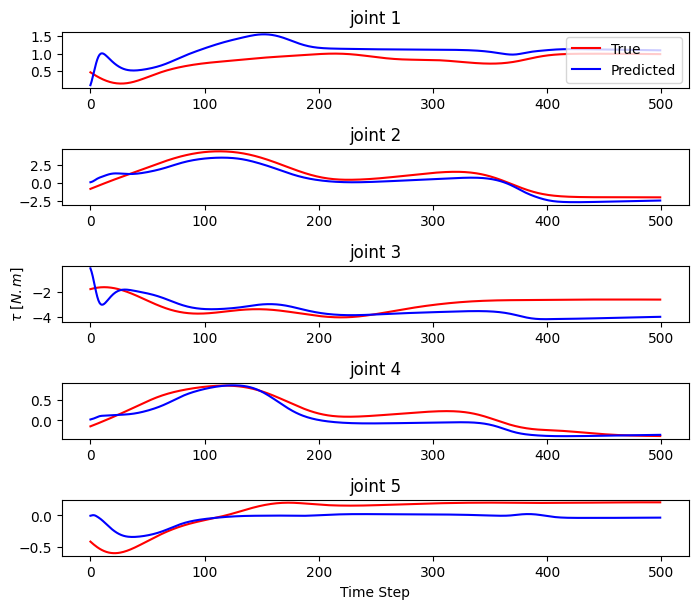

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(val_output[0, :, k], label='True', color='red')
  ax.plot(val_predictions[0, :, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.savefig('output_plot_LSTM_2.png')
plt.show()

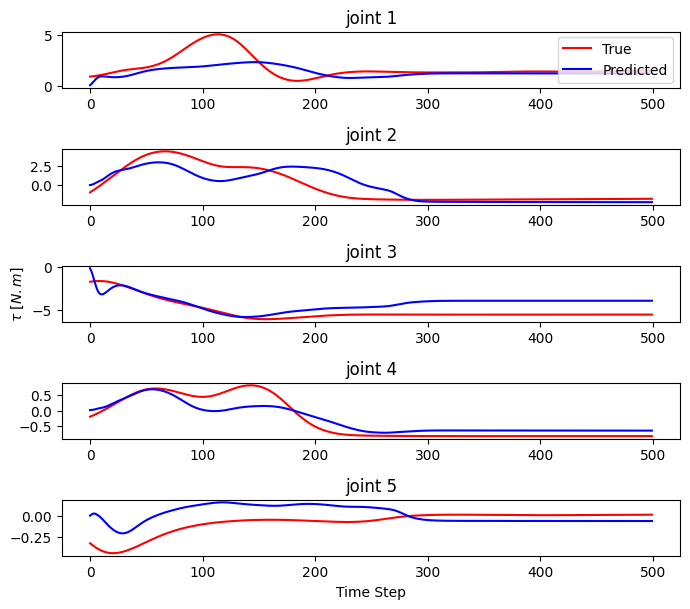

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(val_output[1, :, k], label='True', color='red')
  ax.plot(val_predictions[1, :, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.savefig('output_plot_LSTM_2.png')
plt.show()

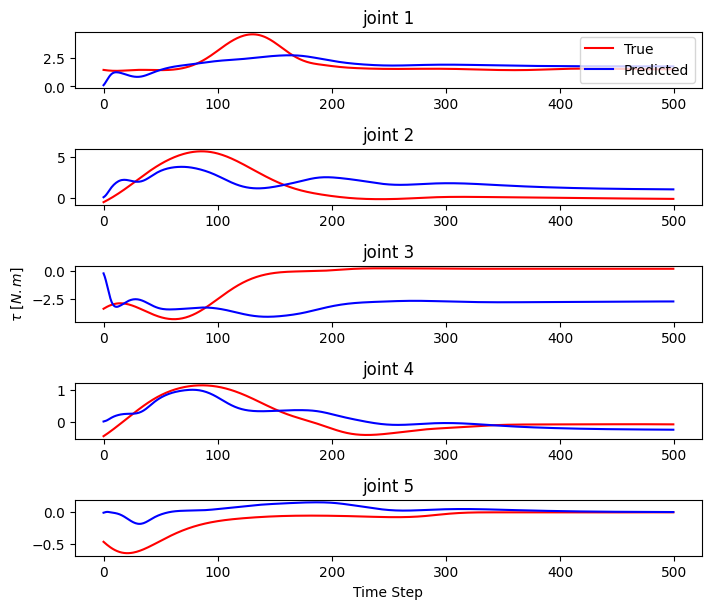

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[0, :, k], label='True', color='red')
  ax.plot(test_predictions[0, :, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.savefig('output_plot_LSTM_2.png')
plt.show()

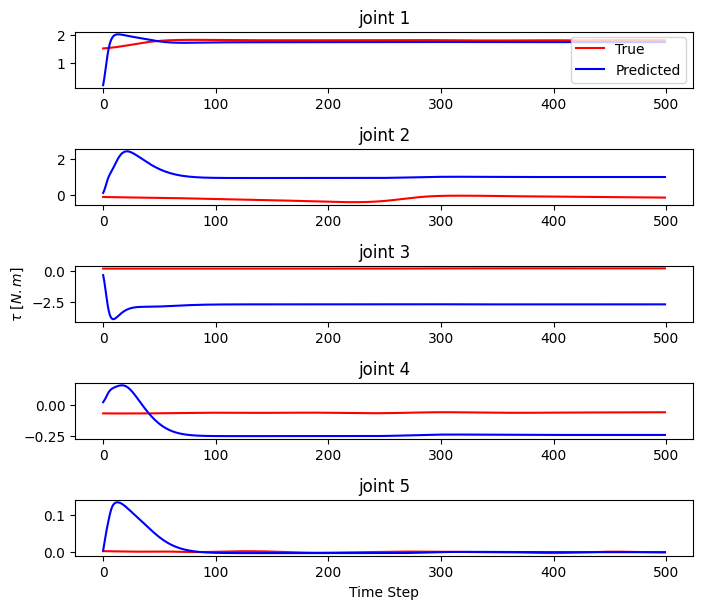

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[1, :, k], label='True', color='red')
  ax.plot(test_predictions[1, :, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.savefig('output_plot_LSTM_2.png')
plt.show()

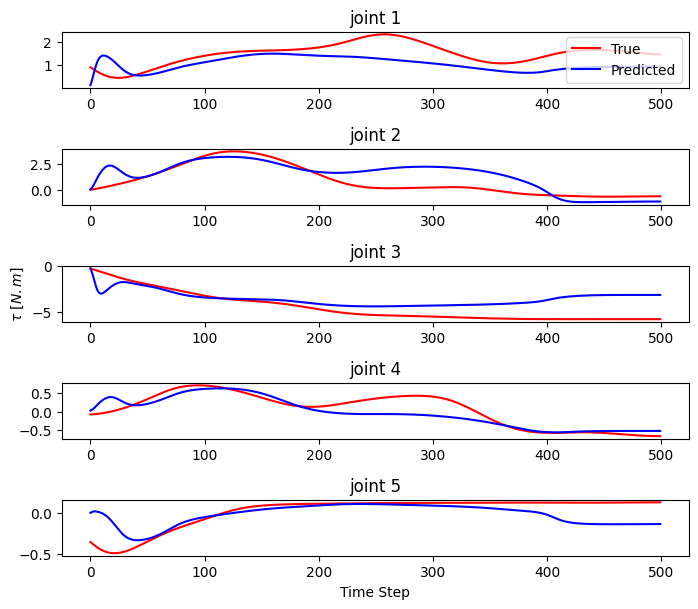

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[2, :, k], label='True', color='red')
  ax.plot(test_predictions[2, :, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.savefig('output_plot_LSTM_2.png')
plt.show()

In [30]:
# Specify the path you need to save the model into
LSTM_NN.save('/content/drive/MyDrive/EECE789K-Project/LSTMM_with_filtering.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
